## Import libraries

In [29]:
import scipy.io as scio
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
data = scio.loadmat('monkeydata_training.mat')
trials = data['trial'].reshape(100,8)

## 1D CNN - Feedforward

In [127]:
class FeedForward(nn.Module):
    def __init__(self,num_layers,layer_size):
        super(FeedForward, self).__init__()
        self.conv = nn.Conv1d(98,20,kernel_size=1,padding='same') 
        self.relu = nn.ReLU()
        
        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(6000, layer_size) 
        
        if num_layers == 2:
            self.feedforward = nn.Sequential(
                nn.ReLU()
            )
        elif num_layers == 3:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU()
            )
        elif num_layers == 4:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU()
            )
       
        self.fc2 = nn.Linear(layer_size, 2)
    
    def forward(self, x):
        output = self.conv(x)
        output = self.relu(output)
        output = self.flat(output)
        output = self.drop(output)
        output = self.fc1(output)
        output = self.feedforward(output)
        output = self.fc2(output)   
        return output

## 2D CNN 

In [7]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(200,100,kernel_size=1,padding='same') 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(100,100,kernel_size=1,padding='same') 
        self.relu2 = nn.ReLU()

        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(400, 100)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)
        self.softmax = nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.relu2(output)
    
        output = self.flat(output)
        output = self.drop(output)
        
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

## RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Train & test functions

In [126]:
def train_model(model, X, Y, learning_rate=0.005, num_epochs=100):
    dataset = torch.utils.data.TensorDataset(X, Y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
            sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=100000, drop_last=False))

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model.train();

    loss_history = []
    for _ in tqdm.trange(num_epochs):
            for _, (inputs, targets) in enumerate(data_loader):
                    optimizer.zero_grad()
                    y_pred = model(inputs)
                    loss = criterion(y_pred, targets)
                    loss.backward()
                    optimizer.step()
                    loss_history.append(loss.item())
                    
    return model

In [124]:
def test_model(model, X, Y):
    model.eval();
    y_pred = model(X) # GIVES ALL NAN :(

    length = len(y_pred)
    results = np.zeros((length,2))
    target  = np.zeros((length,2))
    for i in range(length):
        target[i,:]  = Y[i].detach().numpy()
        results[i,:] = y_pred[i].detach().numpy()
            
    error = np.divide((target - results),target)    
    _, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(error[:,0])
    axs[1].plot(error[:,1])

## Workflow

In [101]:
# Prep data for CNN
# Use data 300ms long in 20ms intervals
# Input  -- (num_segments,98,300) OR 300,98???
# Output -- (deltaX, deltaY)

# Spikes  -- trials[:,:][1] -- (98, length)
# HandPos -- trials[:,:][2] -- (3,  length)

training = trials[:75,:]
testing  = trials[75:,:]

In [105]:
training_X = []
training_Y = []
for i in range(75):
    for j in range(8):
        spikes  = training[i,j][1]
        handpos = training[i,j][2]
        for n in range(int(np.floor((spikes.shape[1]-300)/20))):
            training_X.append(spikes[:,n*20:n*20+300])
            training_Y.append(((handpos[1,n*20+299]-handpos[1,n*20])*100, (handpos[2,n*20+299]-handpos[2,n*20])*100))

training_X = torch.FloatTensor(training_X)
training_Y = torch.FloatTensor(training_Y)

testing_X = []
testing_Y = []
for i in range(25):
    for j in range(8):
        spikes  = testing[i,j][1]
        handpos = testing[i,j][2]
        for n in range(int(np.floor((spikes.shape[1]-300)/20))):
            testing_X.append(spikes[:,n*20:n*20+300])
            testing_Y.append(((handpos[1,n*20+299]-handpos[1,n*20])*100, (handpos[2,n*20+299]-handpos[2,n*20])*100))

testing_X = torch.FloatTensor(testing_X)
testing_Y = torch.FloatTensor(testing_Y)

In [128]:
feedforward = FeedForward(3,20)
feedforward = train_model(feedforward, training_X, training_Y)

100%|██████████| 100/100 [34:32<00:00, 20.72s/it]


tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<SelectBackward0>)


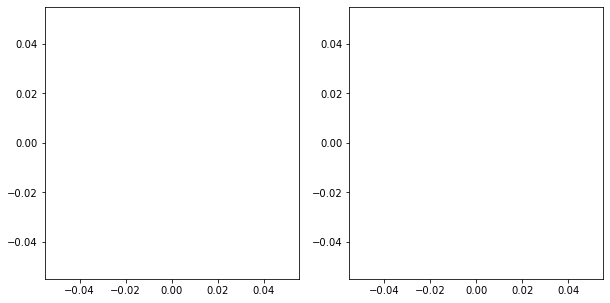

In [125]:
test_model(feedforward, training_X, training_Y)